In [16]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pickle
import math
import torch.nn as nn
from DataLoader import get_dataloader
import matplotlib.pyplot as plt
%matplotlib inline

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_file, transform=None, cache_file='valid_indices_cache.pkl'):
        self.image_dir = image_dir
        self.transform = transform
        self.cache_file = cache_file
        with open(label_file, 'r', encoding='utf-8') as f:
            self.labels = f.readlines()
        self.valid_indices = self._load_or_create_valid_indices()

    def _load_or_create_valid_indices(self):
        if os.path.exists(self.cache_file):
            with open(self.cache_file, 'rb') as f:
                valid_indices = pickle.load(f)
        else:
            valid_indices = self._get_valid_indices()
            with open(self.cache_file, 'wb') as f:
                pickle.dump(valid_indices, f)
        return valid_indices

    def _get_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.labels)):
            img_name = os.path.join(self.image_dir, f"{idx:07d}.png")
            if os.path.exists(img_name):
                valid_indices.append(idx)
        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_name = os.path.join(self.image_dir, f"{actual_idx:07d}.png")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[actual_idx].strip()
        image = self.resize_and_pad(image,800,400)
        if self.transform:
            image = self.transform(image)
        else:
            transform = transforms.Compose([
                transforms.ToTensor()
            ])
            image = transform(image).to("cuda")
        
        return image, label

    def resize_and_pad(self, image, target_width, target_height):
        # Calculate the ratio to maintain the aspect ratio
        original_width, original_height = image.size
        ratio = min(target_width / original_width, target_height / original_height)
    
        # Resize the image while maintaining the aspect ratio
        new_size = (int(original_width * ratio), int(original_height * ratio))
        resized_image = image.resize(new_size, Image.LANCZOS)
    
        # Create a new image with the specified target size and a white background
        new_image = Image.new("RGB", (target_width, target_height), (255, 255, 255))
    
        # Calculate the position to paste the resized image on the white background
        paste_x = (target_width - new_size[0]) // 2
        paste_y = (target_height - new_size[1]) // 2
    
        # Paste the resized image onto the white background
        new_image.paste(resized_image, (paste_x, paste_y))
    
        return new_image

def get_dataloader(batch_size, image_dir='../../UniMER-1M/images/', label_file='../../UniMER-1M/train.txt', transform=None, cache_file='valid_indices_cache.pkl'):
    dataset = CustomDataset(image_dir=image_dir, label_file=label_file, transform=transform, cache_file=cache_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader



In [46]:
class PositionalEncoding2D(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.d_model = d_model
        self.pe: torch.Tensor = self._get_positional_encoding(d_model, height, width)

    def _get_positional_encoding(self, d_model, width, height):
        """
        :param d_model: dimension of the model
        :param height: height of the positions
        :param width: width of the positions
        :return: d_model*height*width position matrix
        """
        if d_model % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(d_model))
        pe = torch.zeros(d_model, height, width)
        # Each dimension use half of d_model
        d_model = int(d_model / 2)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                            -(math.log(10000.0) / d_model))
        pos_w = torch.arange(0., width).unsqueeze(1)
        pos_h = torch.arange(0., height).unsqueeze(1)
        pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
        pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
        pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)

        return pe
    
    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, channels, height, width)
        Returns:
            Tensor with positional encodings added, of shape (batch_size, channels, height, width)
        """
        batch_size, channels, height, width = x.size()
        # Ensure the input has the correct number of channels
        assert self.d_model == channels, "Dimension mismatch: d_model and input channels must be the same"
        # Add positional encodings to the input tensor
        self.pe = self.pe.to(x.device)
        x = x + self.pe.unsqueeze(0) #the unsqueeze() might not be necessary, id
        
        # plt.imshow(self.pe[100], cmap = "gray")
        return x


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

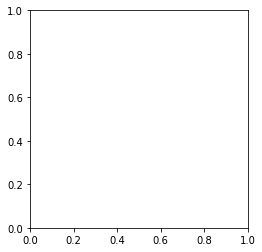

In [24]:
train_loader = get_dataloader(batch_size=10)

# Assuming the DataLoader for training is defined as train_loader
i = 0
test_image = None
for images, labels in train_loader:
    test_image = images[0]
    pil_image = transforms.ToPILImage()(images[0]).convert("RGB")
    # pil_image.show()
    # print(labels[0])    
    plt.imshow(images[0].permute(1, 2, 0))
    
    plt.title(f"Label: {labels[0]}")
    #plt.show()
    if i > 10:
        break
    i += 1

In [25]:
class EncoderToGPT2Adapter(nn.Module):
    def __init__(self, in_channels=1664, out_dim=768):
        super().__init__()
        self.in_channels = in_channels
        self.out_dim = out_dim
        self.projection = nn.Linear(in_channels, out_dim)

    def forward(self, x):
        # x shape: [batch_size, 1664, 12, 25]
        batch_size = x.size(0)
        
        # Reshape: [batch_size, 1664, 12, 25] -> [batch_size, 1664, 300]
        x = x.view(batch_size, self.in_channels, -1)
        
        # Transpose: [batch_size, 1664, 300] -> [batch_size, 300, 1664]
        x = x.transpose(1, 2)
        
        # Project: [batch_size, 300, 1664] -> [batch_size, 300, 768]
        x = self.projection(x)
        
        return x  # Shape: [batch_size, sequence_length, embedding_dim]

In [47]:
import torch
from torchvision import models
from torchvision.models import DenseNet169_Weights

# Load the model with the updated 'weights' parameter
model = models.densenet169(weights=DenseNet169_Weights.IMAGENET1K_V1)
# Remove the final fully connected layer to get the final feature maps
model = nn.Sequential(*list(model.children())[:-1])

# Add PositionalEncoding2D with automated size
model.add_module('PositionalEncoding2D', PositionalEncoding2D(1664, 25, 12))
model.add_module('EncoderToGPT2Adapter', EncoderToGPT2Adapter(in_channels=1664, out_dim=768))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Process the test image
with torch.no_grad():
    i = 0
    for images, labels in train_loader:
        images = images.to(device)
        output = model(images)
        print(output.shape)
        #plt.show()
        if i > 10:
            break
        i += 1

torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])
torch.Size([10, 300, 768])


In [15]:
output = output.squeeze(0)

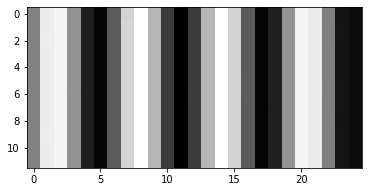

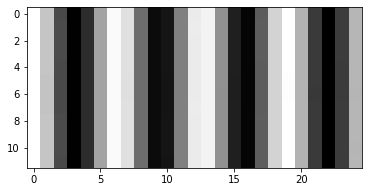

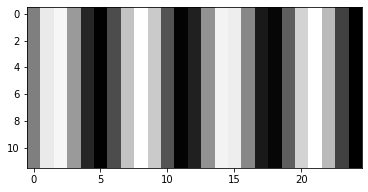

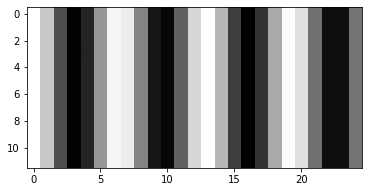

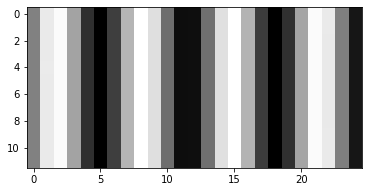

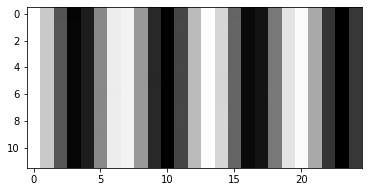

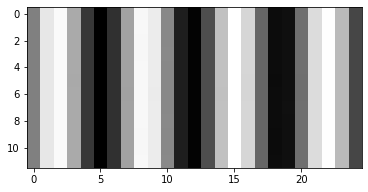

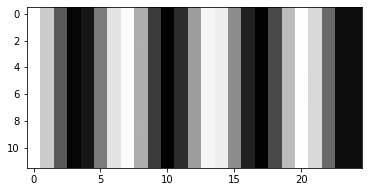

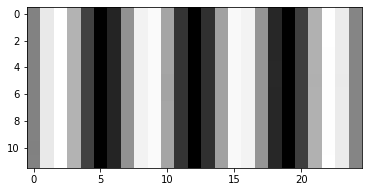

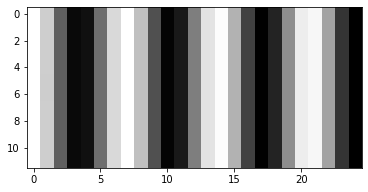

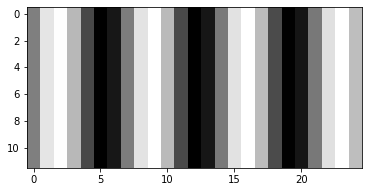

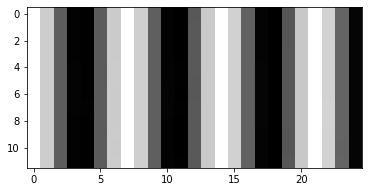

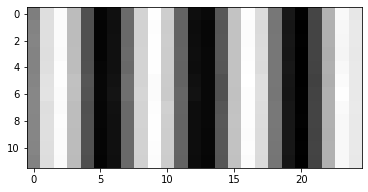

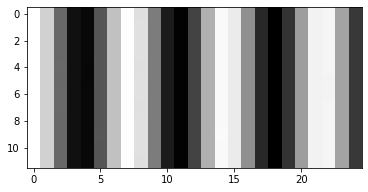

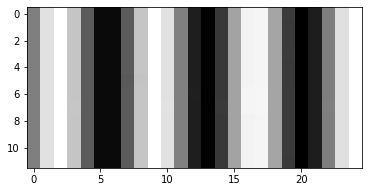

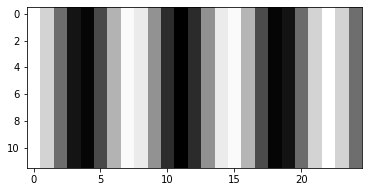

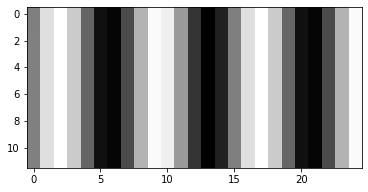

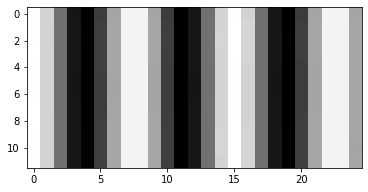

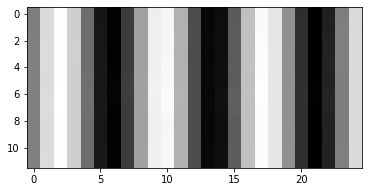

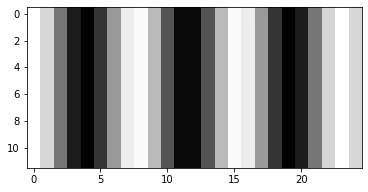

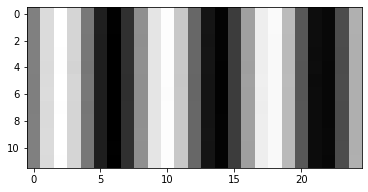

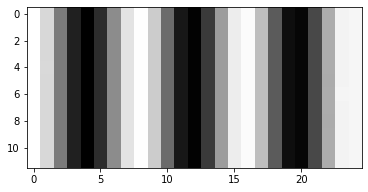

In [11]:
for i in range(output.shape[0]):
    plt.imshow(output[i], cmap = "gray")
    plt.show()
    if i > 20:
        break